In [1]:
import pymongo
import pandas as pd
import json 
import csv
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
movies=pd.read_csv('MOVIES.csv')
movies.head()

,adult,budget,genres,homepage,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,tagline,title,spoken_languages,vote_average,vote_count
0,False,30000000,"Animation, Comedy, Family",http://toystory.disney.com/toy-story,862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,30-10-1995,373554033.0,81.0,Released,NaN,Toy Story,English,7.7,5415.0
1,False,65000000,"Adventure, Fantasy, Family",NaN,8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,15-12-1995,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,"English, Français",6.9,2413.0
2,False,0,"Romance, Comedy",NaN,15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,22-12-1995,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,English,6.5,92.0
3,False,16000000,"Comedy, Drama, Romance",NaN,31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,22-12-1995,81452156.0,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,English,6.1,34.0
4,False,0,Comedy,NaN,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,10-02-1995,76578911.0,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,English,5.7,173.0


In [2]:
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [3]:
db = client["Project"]
movies_metadata= db["movies"]

### Highest Revenue generated movies

In [4]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }}
   }
};

matching= { '$match': { '$and': [ { 'converted_revenue': { '$gt':1000000 } } ] } };

totalPriceCalculationStage = {
   '$project': {'_id':0,"title":1,'revenue': "$converted_revenue", 'vote_average':1 }
};

s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   matching,
   totalPriceCalculationStage,
   { '$sort': { 'revenue': -1 }},
    {'$limit':20}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'title': 'Avatar', 'vote_average': '7.2', 'revenue': 2787965087.0}
{'title': 'Star Wars: The Force Awakens', 'vote_average': '7.5', 'revenue': 2068223624.0}
{'title': 'Titanic', 'vote_average': '7.5', 'revenue': 1845034188.0}
{'title': 'The Avengers', 'vote_average': '7.4', 'revenue': 1519557910.0}
{'title': 'Jurassic World', 'vote_average': '6.5', 'revenue': 1513528810.0}
{'title': 'Avengers: Age of Ultron', 'vote_average': '7.3', 'revenue': 1405403694.0}
{'title': 'Harry Potter and the Deathly Hallows: Part 2', 'vote_average': '7.9', 'revenue': 1342000000.0}
{'title': 'Frozen', 'vote_average': '7.3', 'revenue': 1274219009.0}
{'title': 'Beauty and the Beast', 'vote_average': '6.8', 'revenue': 1262886337.0}
{'title': 'The Fate of the Furious', 'vote_average': '6.8', 'revenue': 1238764765.0}
{'title': 'Iron Man 3', 'vote_average': '6.8', 'revenue': 1215439994.0}
{'title': 'Minions', 'vote_average': '6.4', 'revenue': 1156730962.0}
{'title': 'Transformers: Dark of the Moon', 'vote_averag

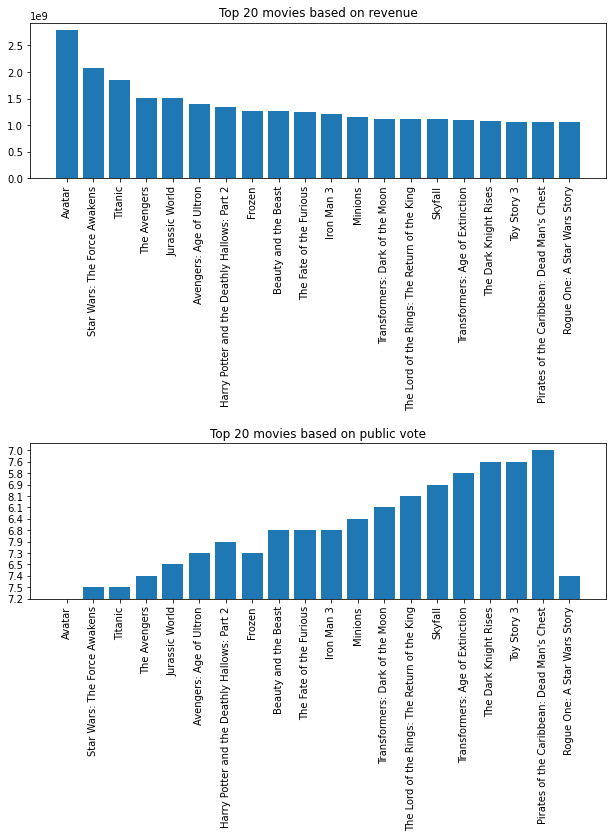

In [5]:
title=[]
revenue=[]
vote_average=[]
for i in ana:
    title.append(i['title'])
    revenue.append(i['revenue'])
    vote_average.append(i['vote_average'])

plt.figure(figsize = (20,20))
plt.subplot(2, 1, 1)
plt.bar(title, revenue)
plt.title('Top 20 movies based on revenue')
plt.xticks(rotation=90)

plt.subplot(2, 1, 2)
plt.bar(title, vote_average)
plt.title('Top 20 movies based on public vote')
plt.xticks(rotation=90)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.5, 
                    top=0.5, 
                    wspace=1, 
                    hspace=1.7)
plt.show()

#### See how English play an important role (wider english audience)

In [6]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };

totalPriceCalculationStage = {
   '$project': {'_id':0,"spoken_languages":1,'revenue': "$converted_revenue" }
};

s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   matching,
   totalPriceCalculationStage,
    {'$match':{'revenue':{'$gt':1000000}}},
    {'$project':{'revenue':0}},
    {'$group' : {'_id' : "$spoken_languages", 'count' : {'$sum' : 1}}},
    { '$sort': { 'count': -1 }},
    {'$limit':21}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'_id': 'English', 'count': 2810}
{'_id': 'English, Español', 'count': 141}
{'_id': 'English, Français', 'count': 104}
{'_id': 'हिन्दी', 'count': 62}
{'_id': 'English, Italiano', 'count': 54}
{'_id': 'Pусский', 'count': 52}
{'_id': 'English, Pусский', 'count': 47}
{'_id': 'Español, English', 'count': 43}
{'_id': 'English, Deutsch', 'count': 42}
{'_id': 'Français, English', 'count': 25}
{'_id': 'Français', 'count': 24}
{'_id': 'English, Português', 'count': 22}
{'_id': 'English, 日本語', 'count': 19}
{'_id': '日本語', 'count': 18}
{'_id': 'Español', 'count': 18}
{'_id': 'English, 普通话', 'count': 17}
{'_id': 'Český, English', 'count': 15}
{'_id': 'Italiano, English', 'count': 14}
{'_id': 'Deutsch, English', 'count': 14}
{'_id': 'Pусский, English', 'count': 13}
{'_id': 'العربية, English', 'count': 13}


C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_

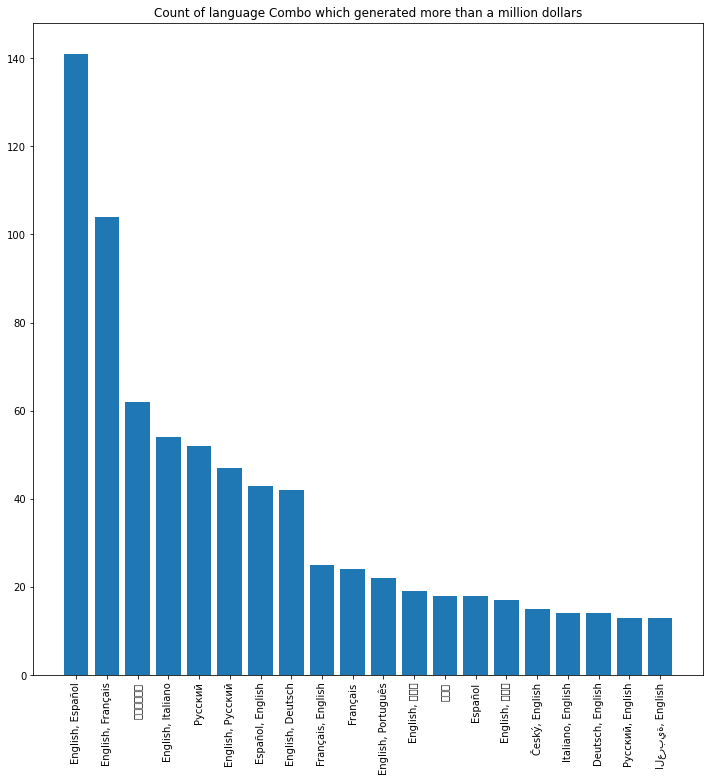

In [7]:
language=[]
count=[]
for i in ana:
    language.append(i['_id'])
    count.append(i['count'])

plt.figure(figsize = (12,12))
plt.bar(language[1:], count[1:])
plt.title('Count of language Combo which generated more than a million dollars')
plt.xticks(rotation=90)
plt.show()

#### Prodcution houses which were able to produce profitable movies

In [8]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   matching,
    {'$match':{'converted_revenue':{'$gt':1000000}}},
    {'$group' : {'_id' : "$production_companies", 'count' : {'$sum' : 1}}},
    {'$match':{'count':{'$gt':5}}},
    { '$sort': { 'count': -1 }}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'_id': 'unk', 'count': 99}
{'_id': 'Paramount Pictures', 'count': 90}
{'_id': 'Universal Pictures', 'count': 59}
{'_id': 'Metro-Goldwyn-Mayer (MGM)', 'count': 53}
{'_id': 'Warner Bros.', 'count': 51}
{'_id': 'Twentieth Century Fox Film Corporation', 'count': 44}
{'_id': 'Columbia Pictures', 'count': 39}
{'_id': 'New Line Cinema', 'count': 38}
{'_id': 'Touchstone Pictures', 'count': 24}
{'_id': 'Walt Disney Pictures', 'count': 23}
{'_id': 'Orion Pictures', 'count': 20}
{'_id': 'Columbia Pictures Corporation', 'count': 19}
{'_id': 'United Artists', 'count': 18}
{'_id': 'TriStar Pictures', 'count': 16}
{'_id': 'Walt Disney Productions', 'count': 14}
{'_id': 'Miramax Films', 'count': 13}
{'_id': 'Dimension Films', 'count': 13}
{'_id': 'DreamWorks Animation', 'count': 12}
{'_id': 'Walt Disney Pictures, Pixar Animation Studios', 'count': 12}
{'_id': 'Yash Raj Films', 'count': 11}
{'_id': 'Imagine Entertainment, Universal Pictures', 'count': 10}
{'_id': 'Universal Pictures, Amblin Entertainm

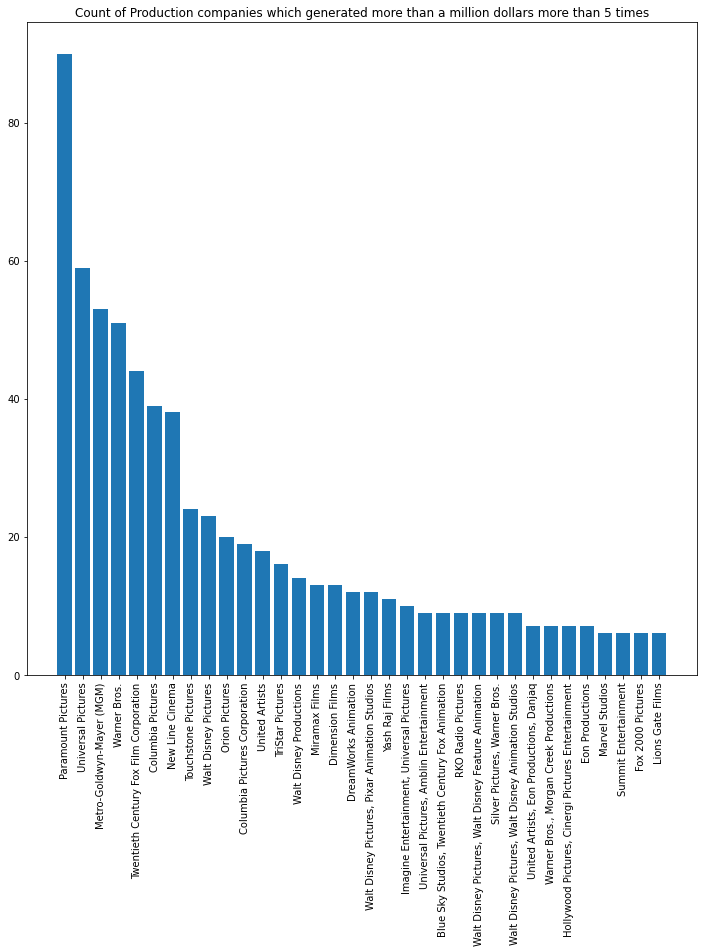

In [16]:
production_company=[]
count=[]
for i in ana:
    production_company.append(i['_id'])
    count.append(i['count'])

plt.figure(figsize = (12,12))
plt.bar(production_company[1:], count[1:])
plt.title('Count of Production companies which generated more than a million dollars more than 5 times')
plt.xticks(rotation=90)
plt.show()

#### Most successful production houses(in terms of total revenue)

In [47]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   matching,
    {'$group' : {'_id' : "$production_companies", 'count' : {'$sum' : '$converted_revenue'}}}, 
    { '$sort': { 'count': -1 }},
    {'$limit':10}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'_id': 'Walt Disney Pictures, Pixar Animation Studios', 'count': 7092295465.0}
{'_id': 'Paramount Pictures', 'count': 6406134311.0}
{'_id': 'DreamWorks Animation', 'count': 5678788108.0}
{'_id': 'Walt Disney Pictures, Walt Disney Animation Studios', 'count': 4855565504.0}
{'_id': 'Blue Sky Studios, Twentieth Century Fox Animation', 'count': 4593632353.0}
{'_id': 'Warner Bros., Heyday Films', 'count': 4168477803.0}
{'_id': 'Marvel Studios', 'count': 4167349882.0}
{'_id': 'Columbia Pictures', 'count': 3252804305.0}
{'_id': 'Universal Pictures, Illumination Entertainment', 'count': 3203800871.0}
{'_id': 'Universal Pictures', 'count': 3027707958.0}


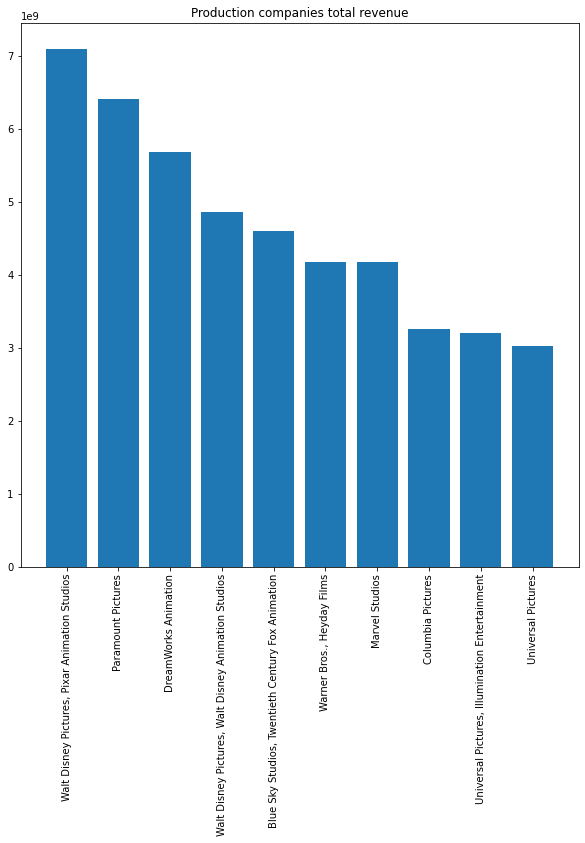

In [48]:
production_company=[]
revenue=[]
for i in ana:
    production_company.append(i['_id'])
    revenue.append(i['count'])

plt.figure(figsize = (10,10))
plt.bar(production_company, revenue)
plt.title('Production companies total revenue')
plt.xticks(rotation=90)
plt.show()

#### Walt Disney Pictures, Pixar Animation Studios trend 

In [19]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
       "created_at": { 
            "$dateFromString": { 
                "dateString": "$release_date",
                "format": "%d-%m-%Y" 
            } 
        }
       
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   {'$match':{"production_companies": "Walt Disney Pictures, Pixar Animation Studios"}},
   priceQtyConversionStage,
   matching,
   {'$project': {'_id':0,'original_title':1,'budget':1,'revenue':1,'created_at':1}},
])
ana=[]
for i in s:
    ana.append(i)
    print(i)

{'budget': '120000000', 'original_title': "A Bug's Life", 'revenue': '363258859.0', 'created_at': datetime.datetime(1998, 11, 25, 0, 0)}
{'budget': '115000000', 'original_title': 'Monsters, Inc.', 'revenue': '562816256.0', 'created_at': datetime.datetime(2001, 11, 1, 0, 0)}
{'budget': '92000000', 'original_title': 'The Incredibles', 'revenue': '631442092.0', 'created_at': datetime.datetime(2004, 11, 5, 0, 0)}
{'budget': '120000000', 'original_title': 'Cars', 'revenue': '461983149.0', 'created_at': datetime.datetime(2006, 6, 8, 0, 0)}
{'budget': '150000000', 'original_title': 'Ratatouille', 'revenue': '623722818.0', 'created_at': datetime.datetime(2007, 6, 22, 0, 0)}
{'budget': '200000000', 'original_title': 'Toy Story 3', 'revenue': '1066969703.0', 'created_at': datetime.datetime(2010, 6, 16, 0, 0)}
{'budget': '200000000', 'original_title': 'Cars 2', 'revenue': '559852396.0', 'created_at': datetime.datetime(2011, 6, 11, 0, 0)}
{'budget': '185000000', 'original_title': 'Brave', 'revenue

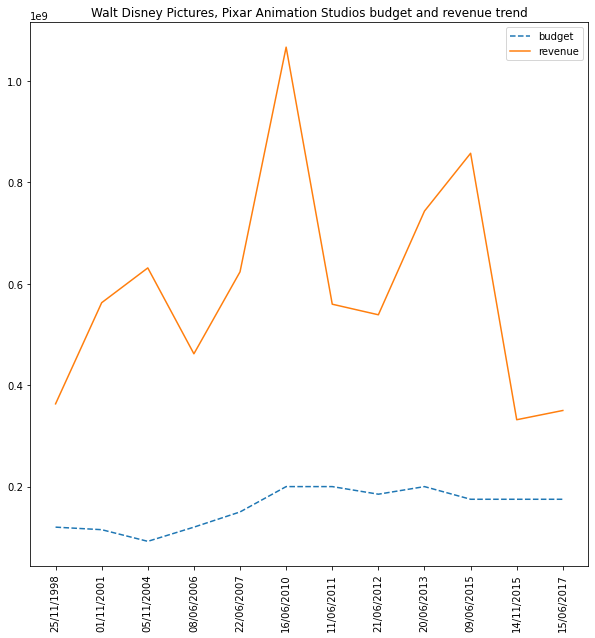

In [20]:
dicta={}
date=[]
budget=[]
revenue=[]
for i in ana:
    dicta[i['created_at'].strftime("%d/%m/%Y")]=(i['original_title'],i['budget'],i['revenue'])
    date.append(i['created_at'].strftime("%d/%m/%Y"))
    budget.append(int(i['budget']))
    revenue.append(float(i['revenue']))

    
plt.figure(figsize = (10,10))
plt.plot(date,budget, label = "budget",linestyle="--")
plt.plot(date,revenue, label = "revenue")
plt.title('Walt Disney Pictures, Pixar Animation Studios budget and revenue trend')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Runtime of Walt Disney Pictures, Pixar Animation Studios

In [6]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
       "created_at": { 
            "$dateFromString": { 
                "dateString": "$release_date",
                "format": "%d-%m-%Y" 
            } 
        }
       
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   {'$match':{"production_companies": "Walt Disney Pictures, Pixar Animation Studios"}},
   priceQtyConversionStage,
   matching,
   {'$project': {'_id':0,'original_title':1,'runtime':1,'vote_average':1}},
   { '$sort': { 'created_at':1}}
])

summ=[]
for i in s:
    summ.append(i)
    print(i)

{'original_title': "A Bug's Life", 'runtime': '95.0', 'vote_average': '6.8'}
{'original_title': 'Monsters, Inc.', 'runtime': '92.0', 'vote_average': '7.5'}
{'original_title': 'The Incredibles', 'runtime': '115.0', 'vote_average': '7.4'}
{'original_title': 'Cars', 'runtime': '117.0', 'vote_average': '6.6'}
{'original_title': 'Ratatouille', 'runtime': '111.0', 'vote_average': '7.5'}
{'original_title': 'Toy Story 3', 'runtime': '103.0', 'vote_average': '7.6'}
{'original_title': 'Cars 2', 'runtime': '106.0', 'vote_average': '5.8'}
{'original_title': 'Brave', 'runtime': '93.0', 'vote_average': '6.7'}
{'original_title': 'Monsters University', 'runtime': '104.0', 'vote_average': '7.0'}
{'original_title': 'Inside Out', 'runtime': '94.0', 'vote_average': '7.9'}
{'original_title': 'The Good Dinosaur', 'runtime': '93.0', 'vote_average': '6.6'}
{'original_title': 'Cars 3', 'runtime': '109.0', 'vote_average': '6.6'}


#### Indian movies

In [65]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   {'$match':{"production_countries": "India"}},
   priceQtyConversionStage,
   matching,
   {'$project': {'_id':0,'original_title':1,'converted_revenue':1}},
   { '$sort': { 'converted_revenue':-1}},
    {'$limit':20}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'original_title': 'दंगल', 'converted_revenue': 310000000.0}
{'original_title': 'Baahubali 2: The Conclusion', 'converted_revenue': 230000000.0}
{'original_title': 'PK', 'converted_revenue': 120000000.0}
{'original_title': 'Sultan', 'converted_revenue': 102000000.0}
{'original_title': 'Baahubali: The Beginning', 'converted_revenue': 100000000.0}
{'original_title': 'Dilwale Dulhania Le Jayenge', 'converted_revenue': 100000000.0}
{'original_title': '7Aum Arivu', 'converted_revenue': 98900000.0}
{'original_title': 'Bajrangi Bhaijaan', 'converted_revenue': 98000000.0}
{'original_title': 'धूम ३', 'converted_revenue': 91000000.0}
{'original_title': 'Ghajini', 'converted_revenue': 76000000.0}
{'original_title': '3 Idiots', 'converted_revenue': 70000000.0}
{'original_title': 'प्रेम रतन धन पायो', 'converted_revenue': 67000000.0}
{'original_title': 'Chennai Express', 'converted_revenue': 62000000.0}
{'original_title': 'எந்திரன்', 'converted_revenue': 62000000.0}
{'original_title': 'Dilwale', 'co

C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2343 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hp\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 2409 missing from current font.
  font.set_

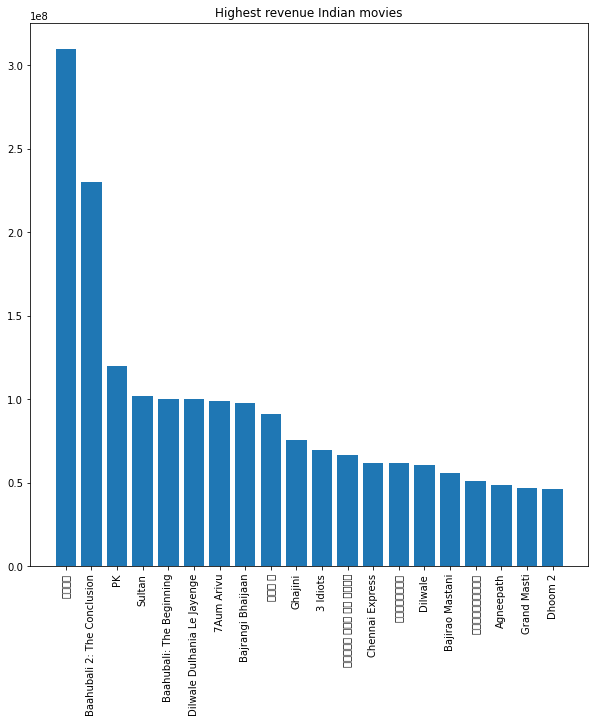

In [66]:
title=[]
converted_revenue=[]
for i in ana:
    title.append(i['original_title'])
    converted_revenue.append(i['converted_revenue'])

plt.figure(figsize = (10,10))
plt.bar(title, converted_revenue)
plt.title('Highest revenue Indian movies')
plt.xticks(rotation=90)
plt.show()

#### Most favourite Indian movie

In [71]:
s=db.movies_metadata.aggregate( [
   {'$match':{"production_countries": "India"}},
   {'$project': {'_id':0,'original_title':1,'vote_average':1}},
   { '$sort': { 'vote_average':-1}},
   {'$limit':20}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'original_title': 'Dilwale Dulhania Le Jayenge', 'vote_average': '9.1'}
{'original_title': 'कट्यार काळजात घुसली', 'vote_average': '9.0'}
{'original_title': 'Tashi and the Monk', 'vote_average': '9.0'}
{'original_title': 'Shree 420', 'vote_average': '9.0'}
{'original_title': 'English, August', 'vote_average': '9.0'}
{'original_title': 'സന്ദേശം', 'vote_average': '8.8'}
{'original_title': 'Natsamrat', 'vote_average': '8.8'}
{'original_title': 'सैराट', 'vote_average': '8.7'}
{'original_title': 'జెంటిల్మేన్', 'vote_average': '8.5'}
{'original_title': 'Daayen Ya Baayen', 'vote_average': '8.5'}
{'original_title': 'യോദ്ധാ', 'vote_average': '8.3'}
{'original_title': 'Fakta Ladh Mhana', 'vote_average': '8.3'}
{'original_title': 'Prahaar: The Final Attack', 'vote_average': '8.3'}
{'original_title': 'অপুর সংসার', 'vote_average': '8.2'}
{'original_title': 'Kaaka Muttai', 'vote_average': '8.2'}
{'original_title': 'Ganashatru', 'vote_average': '8.2'}
{'original_title': 'ദൃശ്യം', 'vote_average': '8.1

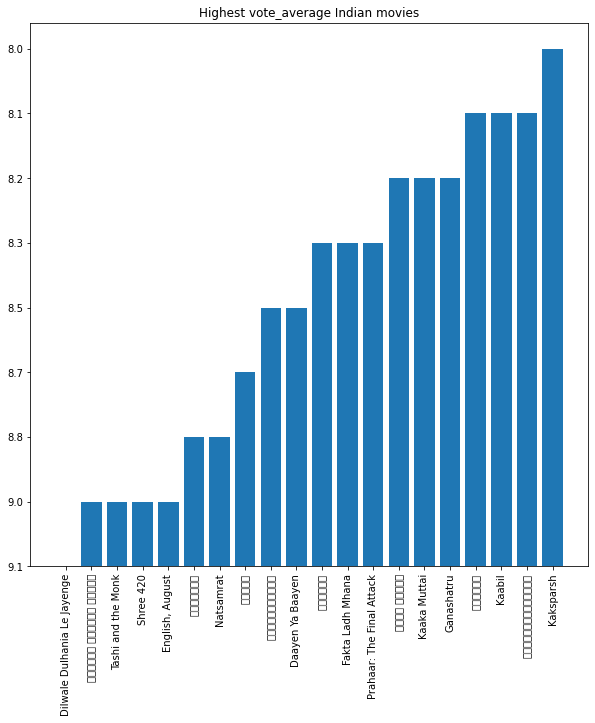

In [75]:
title=[]
vote_average=[]
for i in ana:
    title.append(i['original_title'])
    vote_average.append(i['vote_average'])

plt.figure(figsize = (10,10))
plt.bar(title, vote_average)
plt.title('Highest vote_average Indian movies')
plt.xticks(rotation=90)
plt.show()

In [78]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   {'$match':{"production_countries": "India"}},
   priceQtyConversionStage,
   matching,
    {'$match':{'converted_revenue':{'$gt':1000000}}},
    {'$group' : {'_id' : "$production_companies", 'count' : {'$sum' : 1}}},
    {'$match':{'count':{'$gt':1}}},
    { '$sort': { 'count': -1 }}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'_id': 'unk', 'count': 16}
{'_id': 'Yash Raj Films', 'count': 10}
{'_id': 'UTV Motion Pictures', 'count': 4}
{'_id': 'Dharma Productions', 'count': 3}
{'_id': 'Arka Media Works', 'count': 2}
{'_id': 'Madras Talkies', 'count': 2}
{'_id': 'AVM Productions', 'count': 2}
{'_id': 'Studio Green, Thirukumaran Entertainment', 'count': 2}
{'_id': 'Red Chillies Entertainment', 'count': 2}
{'_id': 'Sun Pictures', 'count': 2}
{'_id': 'Reliance Entertainment', 'count': 2}


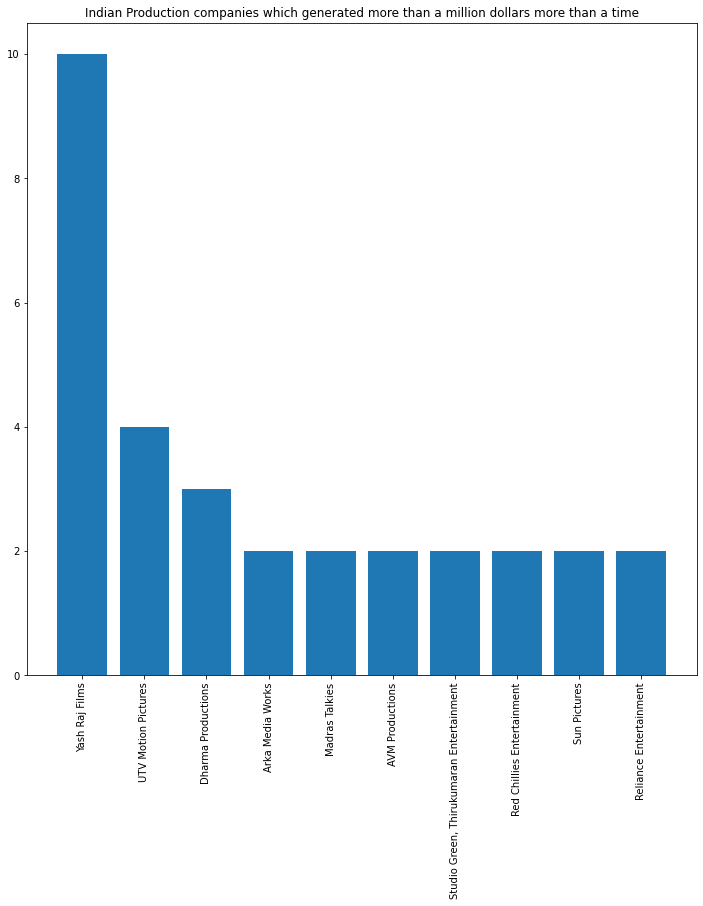

In [79]:
production_company=[]
count=[]
for i in ana:
    production_company.append(i['_id'])
    count.append(i['count'])

plt.figure(figsize = (12,12))
plt.bar(production_company[1:], count[1:])
plt.title('Indian Production companies which generated more than a million dollars more than a time')
plt.xticks(rotation=90)
plt.show()

#### Movies produced by Yash-raj

In [128]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
         "created_at": { 
            "$dateFromString": { 
                "dateString": "$release_date",
                "format": "%d-%m-%Y" 
            } 
        }
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   {'$match':{"production_companies": "Yash Raj Films"}},
   priceQtyConversionStage,
   matching,
   {'$project': {'_id':0,'original_title':1,'revenue':1,'budget':1,'release_date':1}},
   { '$sort': { 'release_date':1}}
])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'budget': '10400000', 'original_title': 'Sultan', 'release_date': '06-07-2016', 'revenue': '102000000.0'}
{'budget': '6250000', 'original_title': 'Badmaa$h Company', 'release_date': '07-05-2010', 'revenue': '8500000.0'}
{'budget': '5510000', 'original_title': 'Mere Brother Ki Dulhan', 'release_date': '09-09-2011', 'revenue': '18050000.0'}
{'budget': '7000000', 'original_title': 'Veer-Zaara', 'release_date': '12-11-2004', 'revenue': '29385320.0'}
{'budget': '2400000', 'original_title': 'Bachna Ae Haseeno', 'release_date': '14-08-2008', 'revenue': '9600000.0'}
{'budget': '19500000', 'original_title': 'धूम ३', 'release_date': '18-12-2013', 'revenue': '91000000.0'}
{'budget': '13200000', 'original_title': 'Dilwale Dulhania Le Jayenge', 'release_date': '20-10-1995', 'revenue': '100000000.0'}
{'budget': '11000000', 'original_title': 'Dhoom 2', 'release_date': '24-11-2006', 'revenue': '46396427.0'}
{'budget': '5300000', 'original_title': 'Fanaa', 'release_date': '26-05-2006', 'revenue': '221

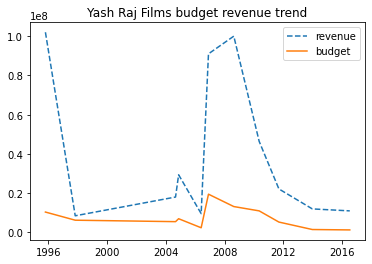

In [132]:
release_date=[]
original_title=[]
revenue=[]
budget=[]

for i in ana:
    release_date.append(datetime.strptime(i['release_date'], '%d-%m-%Y'))
    original_title.append(i['original_title'])
    revenue.append(int(float(i['revenue'])))
    budget.append(int(float(i['budget'])))
release_date.sort()

    
#plt.figure(figsize = (10,10))
plt.plot(release_date,revenue, label = "revenue",linestyle="--")
plt.plot(release_date,budget, label = "budget",linestyle="-")
plt.title('Yash Raj Films budget revenue trend')
plt.legend()
plt.show()

#### Popularity

In [135]:
s=db.movies_metadata.aggregate([ 
    
    
    {'$addFields': {
    
            'converted_popularity': { '$convert': { 
              'input': "$popularity", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }}
  
        
    }},
                                {'$group' : {'_id' : "$genres", 'count' : {'$sum' : '$converted_popularity'}}},
                               {'$project': {'_id':1,'count':1}},
                               {'$sort':{ 'count':-1}},
{'$limit':20} ])

ana=[]
for i in s:
    ana.append(i)
    print(i)

{'_id': 'Drama', 'count': 9358.685363}
{'_id': 'Comedy', 'count': 7907.157106}
{'_id': 'Drama, Romance', 'count': 3516.605127}
{'_id': 'Comedy, Drama', 'count': 3091.289736}
{'_id': 'Comedy, Romance', 'count': 2549.821516}
{'_id': 'Horror', 'count': 2435.453475}
{'_id': 'Comedy, Drama, Romance', 'count': 2355.457366}
{'_id': 'Horror, Thriller', 'count': 2225.744183}
{'_id': 'Documentary', 'count': 2166.552291}
{'_id': 'Drama, Thriller', 'count': 1689.521065}
{'_id': 'Action, Thriller', 'count': 1366.36529}
{'_id': 'Crime, Drama', 'count': 1150.916323}
{'_id': 'Drama, Comedy', 'count': 1143.411494}
{'_id': 'Thriller', 'count': 1110.493863}
{'_id': 'Crime, Drama, Thriller', 'count': 1005.294968}
{'_id': 'Drama, History', 'count': 895.609022}
{'_id': 'Animation, Family', 'count': 890.698138}
{'_id': 'Action, Comedy', 'count': 806.655767}
{'_id': 'Action, Crime, Thriller', 'count': 743.17984}
{'_id': 'unk', 'count': 730.085507}


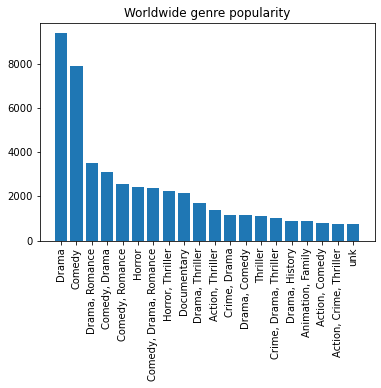

In [136]:
genre=[]
popularity=[]
for i in ana:
    genre.append(i['_id'])
    popularity.append(i['count'])

plt.bar(genre, popularity)
plt.title('Worldwide genre popularity')
plt.xticks(rotation=90)
plt.show()

#### Which production company is successful at producing drama

In [150]:
s=db.movies_metadata.aggregate( [
    
    {'$match':{"genres": "Drama"}},
    {'$group' : {'_id' : "$production_companies", 'count' : {'$sum' : 1}}},
    {'$project': {'_id':1,'count':1}},
    { '$sort': { 'count':-1}},
    {'$limit':11}
   
])
ana=[]
for i in s:
    ana.append(i)
    print(i)

{'_id': 'unk', 'count': 1126}
{'_id': 'Metro-Goldwyn-Mayer (MGM)', 'count': 92}
{'_id': 'Warner Bros.', 'count': 58}
{'_id': 'Twentieth Century Fox Film Corporation', 'count': 45}
{'_id': 'Paramount Pictures', 'count': 38}
{'_id': 'Shôchiku Eiga', 'count': 26}
{'_id': 'RKO Radio Pictures', 'count': 25}
{'_id': 'Columbia Pictures Corporation', 'count': 22}
{'_id': 'Mosfilm', 'count': 18}
{'_id': 'Universal Pictures', 'count': 17}
{'_id': 'Columbia Pictures', 'count': 16}


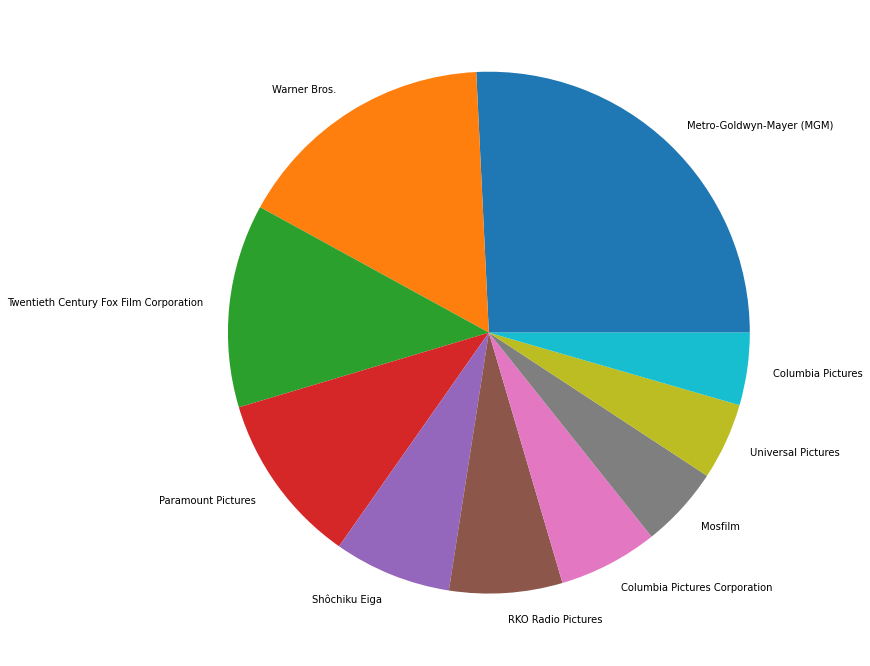

In [155]:
prod_house=[]
count=[]
for i in ana[1:]:
    prod_house.append(i['_id'])
    count.append(i['count'])

plt.figure(figsize = (12,12))   
plt.pie(np.array(count), labels = prod_house)
plt.show() 

#### List of top 10 Dramas based on popularity

In [156]:
s=db.movies_metadata.aggregate( [
   {'$match':{"genres": "Drama"}},
    { '$sort': { 'popularity':-1}},
    { '$limit' : 10},
   {'$project': {'_id':0,'original_title':1,'runtime':1,'popularity':1}}
   
])

for i in s:
    print(i)

{'original_title': "Lorenzo's Oil", 'popularity': '9.968395', 'runtime': '135.0'}
{'original_title': 'Den sommeren jeg fylte 15', 'popularity': '9.95301', 'runtime': '98.0'}
{'original_title': 'Il conformista', 'popularity': '9.931025', 'runtime': '107.0'}
{'original_title': 'Little Birds', 'popularity': '9.920478999999998', 'runtime': '94.0'}
{'original_title': '20th Century Women', 'popularity': '9.855927000000001', 'runtime': '119.0'}
{'original_title': "Get Rich or Die Tryin'", 'popularity': '9.820229', 'runtime': '117.0'}
{'original_title': 'Invincible', 'popularity': '9.794881', 'runtime': '105.0'}
{'original_title': 'Goal!: The Dream Begins', 'popularity': '9.783762', 'runtime': '118.0'}
{'original_title': 'The Other Boleyn Girl', 'popularity': '9.778825999999999', 'runtime': '115.0'}
{'original_title': 'Iron Jawed Angels', 'popularity': '9.771121', 'runtime': '125.0'}


#### Top 30 dramas with highest vote average (Common words) 

In [280]:
## anything common between the top 30 dramas?
s=db.movies_metadata.aggregate( [
    
    {'$match':{"genres": "Drama"}},
    { '$sort': { 'popularity':-1}},
    { '$limit' : 50},
    {'$project': {'_id':0,'overview':1}}
])

ana=[]
for i in s:
    ana.append(i)

overview=[]
for i in ana:
    overview.append(i['overview'])
    
def freq(str):
    word_count={}
    # break the string into list of words 
    str = str.split()         
    str2 = []
  
    # loop till string values present in list str
    for i in str:             
  
        # checking for the duplicacy
        if i not in str2:
  
            # insert value in str2
            str2.append(i) 
              
    for i in range(0, len(str2)):
  
        if(str.count(str2[i])>10):
            word_count[str2[i]]= str.count(str2[i])
    return word_count

lis=freq(' '.join(overview))
print(dict(sorted(lis.items(), key=lambda item: item[1])))

{'A': 11, 'they': 12, 'that': 13, 'on': 13, 'he': 17, 'by': 17, 'an': 20, 'who': 20, 'their': 21, 'for': 22, 'her': 24, 'with': 26, 'in': 33, 'is': 34, 'his': 41, 'and': 73, 'of': 77, 'to': 86, 'a': 88, 'the': 122}


#### Paramount Genre split

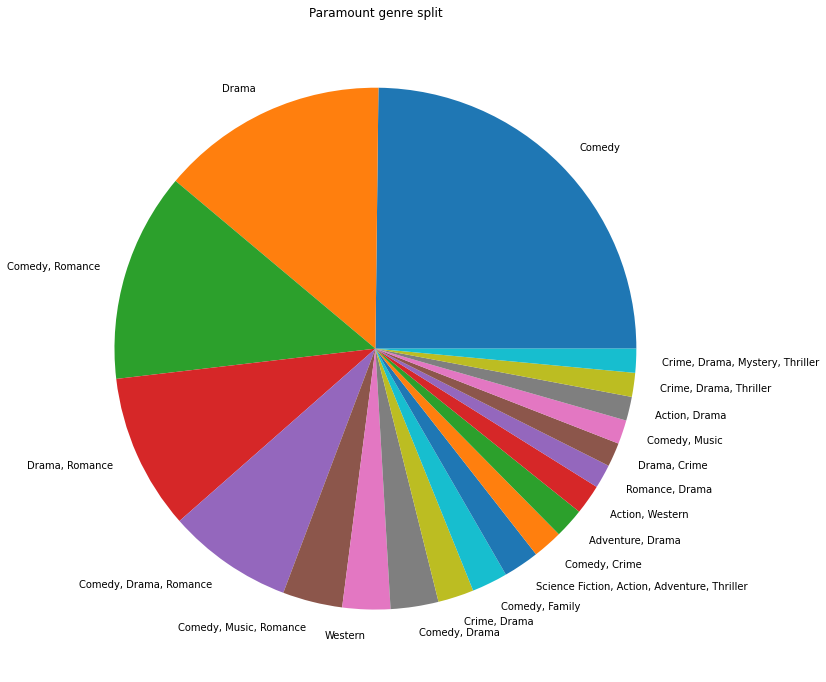

In [203]:
s=db.movies_metadata.aggregate( [
    {'$match':{"production_companies": "Paramount Pictures"}},
    {'$group' : {'_id' : "$genres", 'count' : {'$sum' :1}}}, 
    { '$sort': { 'count': -1 }},
    {'$project': {'_id':1,'count':1}},
    {'$limit':20}
    
    
])

ana=[]
for i in s:
    ana.append(i)

genre=[]
count=[]
for i in ana:
    genre.append(i['_id'])
    count.append(i['count'])

plt.figure(figsize = (12,12))   
plt.pie(np.array(count), labels = genre)
plt.title('Paramount genre split')
plt.show()     

#### Average runtime for production houses

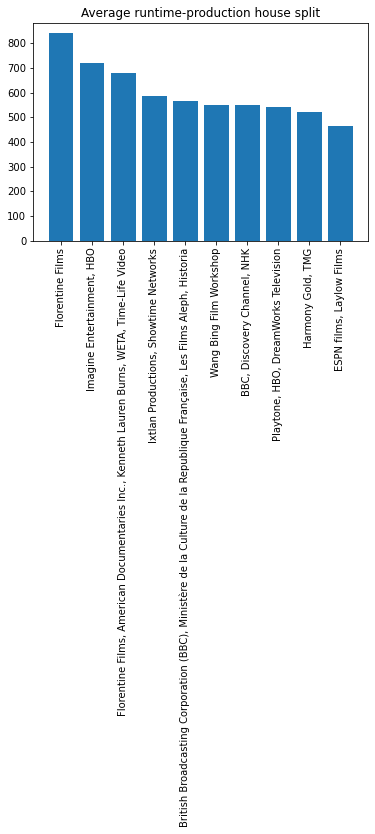

In [209]:
## average runtime
priceQtyConversionStage = {
   '$addFields': {
      'converted_runtime': { '$convert': { 
              'input': "$runtime", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
   }
};



s=db.movies_metadata.aggregate( [
    priceQtyConversionStage,
    {'$group' : {'_id' : '$production_companies', 'count' : {'$avg' :"$converted_runtime"}}}, 
    { '$sort': { 'count': -1 }},
    {'$project': {'_id':1,'production_companies':1,'count':1}},
    {'$limit':10}
    
])

ana=[]
for i in s:
    ana.append(i)

prod_hou=[]
count=[]
for i in ana:
    prod_hou.append(i['_id'])
    count.append(i['count'])

plt.bar(prod_hou, count)
plt.xticks(rotation=90)
plt.title('Average runtime-production house split')
plt.show()     

#### MIlitary word trend

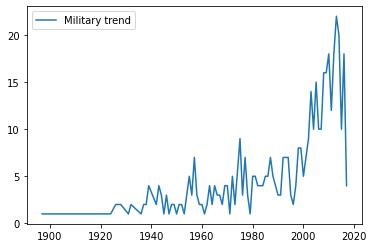

In [243]:
db.movies_metadata.drop_index( "plt_index" )
db.movies_metadata.create_index(name='plt_index', keys=[('overview', "text")], default_language='english',language_override='english')
query=db.movies_metadata.aggregate([ 
    { '$match': {"$text": {"$search": "Military"}}},
    { '$project' : {'_id':0,'title':1,'release_date':1}}
])
ana=[]
for i in query:
    ana.append(i)
    
release_date=[]   
for i in ana:
    release_date.append(datetime.strptime(i['release_date'], '%d-%m-%Y').year)

release_date.sort()

from collections import Counter
s=Counter(release_date)

plt.plot(list(dict(s).keys()),list(dict(s).values()),label='Military trend')
plt.legend()
plt.show()   

#### Comedy Horror trend

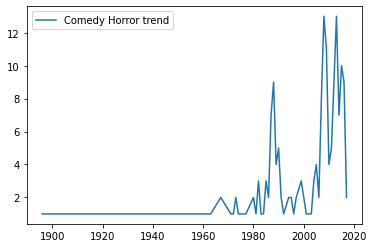

In [249]:
priceQtyConversionStage = {
   '$addFields': {
       
       'converted_popularity': { '$convert': { 
              'input': "$popularity", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
   }
};

matching= { '$match': { 'genres': { '$eq': 'Comedy, Horror' } }};


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   matching,
   {'$group' : {'_id' : '$release_date', 'count' : {'$sum' :1}}},
   {'$project': {'_id':1,'count':1}},  
    { '$sort': { 'count':-1}}
])

ana=[]
for i in s:
    ana.append(i)
    
release_date=[]   
for i in ana:
    release_date.append(datetime.strptime(i['_id'], '%d-%m-%Y').year)

release_date.sort()

from collections import Counter
s=Counter(release_date)

plt.plot(list(dict(s).keys()),list(dict(s).values()),label='Comedy Horror trend')
plt.legend()
plt.show()   

#### Crime, Mystery, Thriller trend

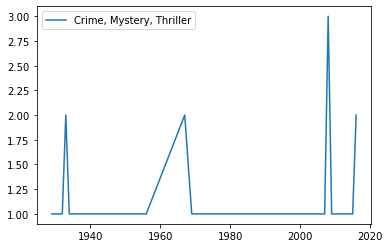

In [279]:
matching= { '$match': { 'genres': { '$eq': 'Crime, Mystery, Thriller' } }};


s=db.movies_metadata.aggregate( [
   matching,
   {'$group' : {'_id' : '$release_date', 'count' : {'$sum' :1}}},
   {'$project': {'_id':1}},  
    { '$sort': { 'count':-1}}
])

ana=[]
for i in s:
    ana.append(i)
    
release_date=[]   
for i in ana:
    release_date.append(datetime.strptime(i['_id'], '%d-%m-%Y').year)

release_date.sort()

from collections import Counter
s=Counter(release_date)

plt.plot(list(dict(s).keys()),list(dict(s).values()),label='Crime, Mystery, Thriller')
plt.legend()
plt.show()   

#### Global revenue

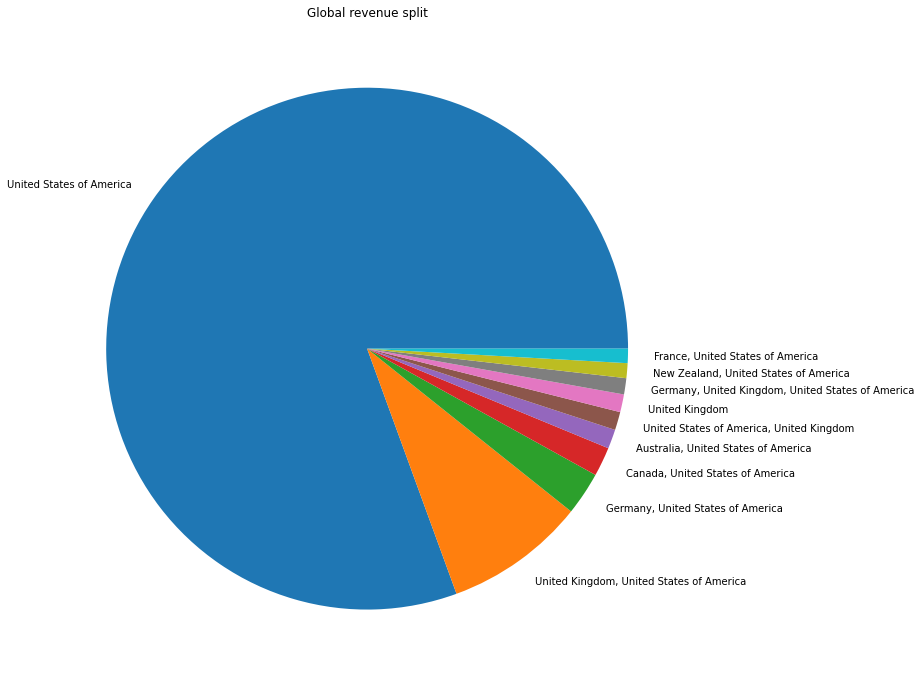

In [257]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   matching,
    {'$group' : {'_id' : "$production_countries", 'count' : {'$sum' : '$converted_revenue'}}}, 
    { '$sort': { 'count': -1 }},
    {'$project':{'_id':1,'count':1}},
    {'$limit':10}
])

ana=[]
for i in s:
    ana.append(i)
    


country=[]
count=[]
for i in ana:
    country.append(i['_id'])
    count.append(i['count'])

plt.figure(figsize = (12,12))   
plt.pie(np.array(count), labels = country)
plt.title('Global revenue split')
plt.show()     

#### USA revenue trend

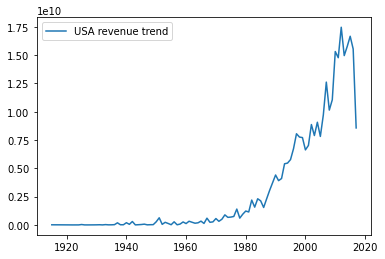

In [277]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
        "created_at": { 
            "$dateFromString": { 
                "dateString": "$release_date",
                "format": "%d-%m-%Y" 
            } 
        }
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   {'$match':{'production_countries':'United States of America'}},
   matching,
    {'$group' : {'_id' : "$release_date", 'count' : {'$sum' : '$converted_revenue'}}}, 
    {'$sort':{'created_at':1}}
])

ana=[]
for i in s:
    ana.append(i)
    
release_year=[]
rev=[]
for i in ana:
    release_year.append(datetime.strptime(i['_id'], '%d-%m-%Y').year)
    rev.append(i['count'])

final=np.unique(np.array(release_year))
year_revenue={}
for j in final:
    indices = [i for i, x in enumerate(release_year) if x == j]
    summ=0
    for ind in indices:
        summ+=rev[ind]
    year_revenue[j]=summ


plt.plot(list(year_revenue.keys()),list(year_revenue.values()),label='USA revenue trend')
plt.legend()
plt.show()   

#### Science Fiction World count

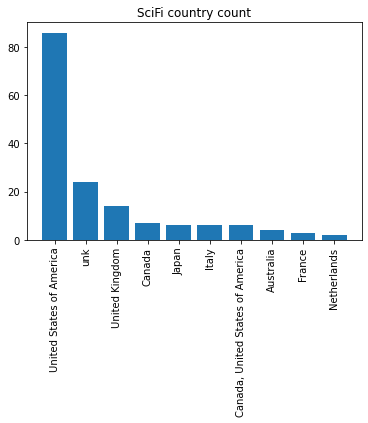

In [282]:
s=db.movies_metadata.aggregate( [
   {'$match':{'genres':'Science Fiction'}},
    {'$group' : {'_id' : "$production_countries", 'count' : {'$sum' : 1}}}, 
    {'$sort':{'count':-1}},
     {'$limit':10}
])

ana=[]
for i in s:
    ana.append(i)

prod_count=[]
count=[]
for i in ana:
    prod_count.append(i['_id'])
    count.append(i['count'])

plt.bar(prod_count, count)
plt.xticks(rotation=90)
plt.title('SciFi country count')
plt.show()     

#### India trend revenue

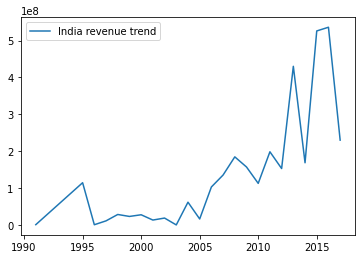

In [278]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
        "created_at": { 
            "$dateFromString": { 
                "dateString": "$release_date",
                "format": "%d-%m-%Y" 
            } 
        }
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   {'$match':{'production_countries':'India'}},
   matching,
    {'$group' : {'_id' : "$release_date", 'count' : {'$sum' : '$converted_revenue'}}}, 
    {'$sort':{'created_at':1}}
])

ana=[]
for i in s:
    ana.append(i)
    
release_year=[]
rev=[]
for i in ana:
    release_year.append(datetime.strptime(i['_id'], '%d-%m-%Y').year)
    rev.append(i['count'])

final=np.unique(np.array(release_year))
year_revenue={}
for j in final:
    indices = [i for i, x in enumerate(release_year) if x == j]
    summ=0
    for ind in indices:
        summ+=rev[ind]
    year_revenue[j]=summ


plt.plot(list(year_revenue.keys()),list(year_revenue.values()),label='India revenue trend')
plt.legend()
plt.show()  

#### Indian Genre count

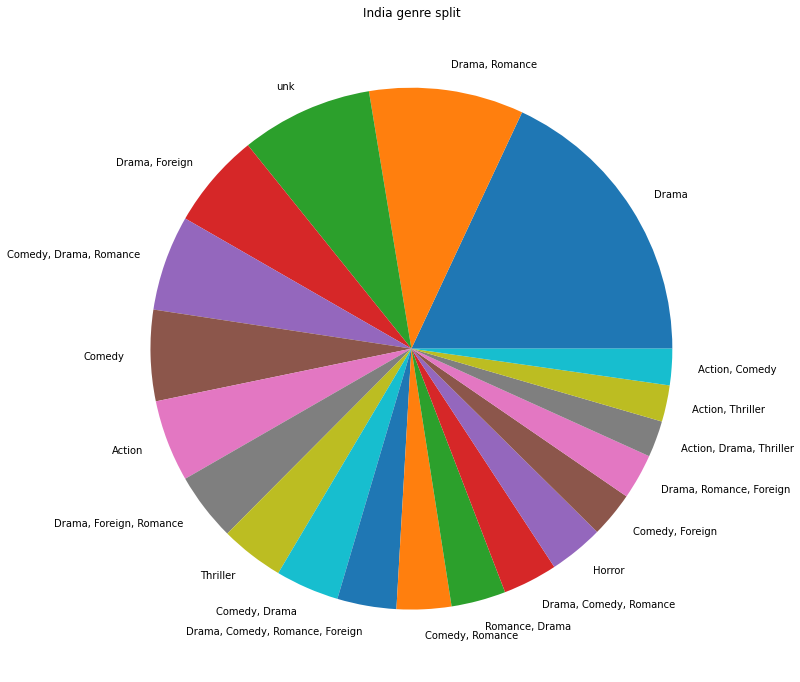

In [281]:
s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   {'$match':{'production_countries':'India'}},
    {'$group' : {'_id' : "$genres", 'count' : {'$sum' : 1}}}, 
    {'$sort':{'count':-1}},
    {'$limit':20}
])

ana=[]
for i in s:
    ana.append(i)
    
genre=[]
count=[]
for i in ana:
    genre.append(i['_id'])
    count.append(i['count'])

plt.figure(figsize = (12,12))   
plt.pie(np.array(count), labels = genre)
plt.title('India genre split')
plt.show()     

#### Indian Production company total revenue

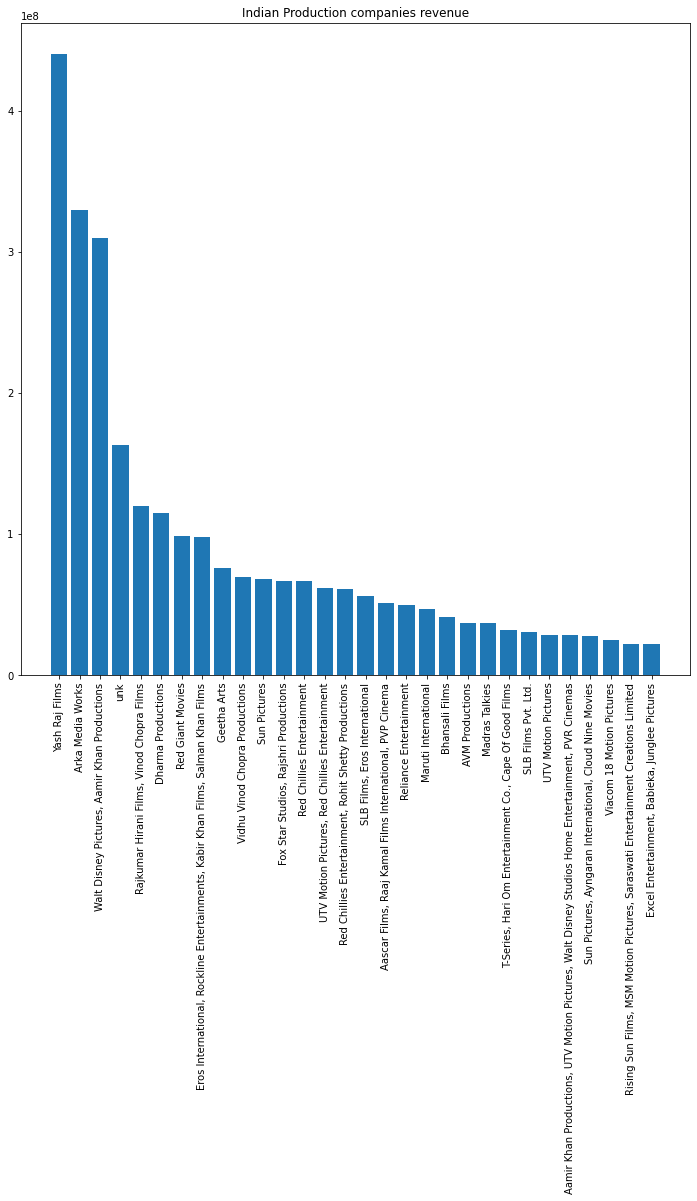

In [283]:
priceQtyConversionStage = {
   '$addFields': {
      'converted_budget': { '$convert': { 
              'input': "$budget", 
              'to': "int",
              'onError': int("0"),
              'onNull': int("0") 
            }},
       
      'converted_revenue': { '$convert': { 
              'input': "$revenue", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
        "created_at": { 
            "$dateFromString": { 
                "dateString": "$release_date",
                "format": "%d-%m-%Y" 
            } 
        }
   }
};

matching= { '$match': { '$and': [ { 'converted_budget': { '$gt':0 } }, { 'converted_revenue': { '$gt' :0 } } ] } };


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   {'$match':{'production_countries':'India'}},
   matching,
    {'$group' : {'_id' : "$production_companies", 'count' : {'$sum' : '$converted_revenue'}}}, 
    {'$sort':{'count':-1}},
    {'$limit':30}
])

ana=[]
for i in s:
    ana.append(i)
    
prod_comp=[]
reve=[]
for i in ana:
    prod_comp.append(i['_id'])
    reve.append(i['count'])


plt.figure(figsize = (12,12))
plt.bar(prod_comp, reve)
plt.title('Indian Production companies revenue')
plt.xticks(rotation=90)
plt.show()

#### Genre based on popularity in India

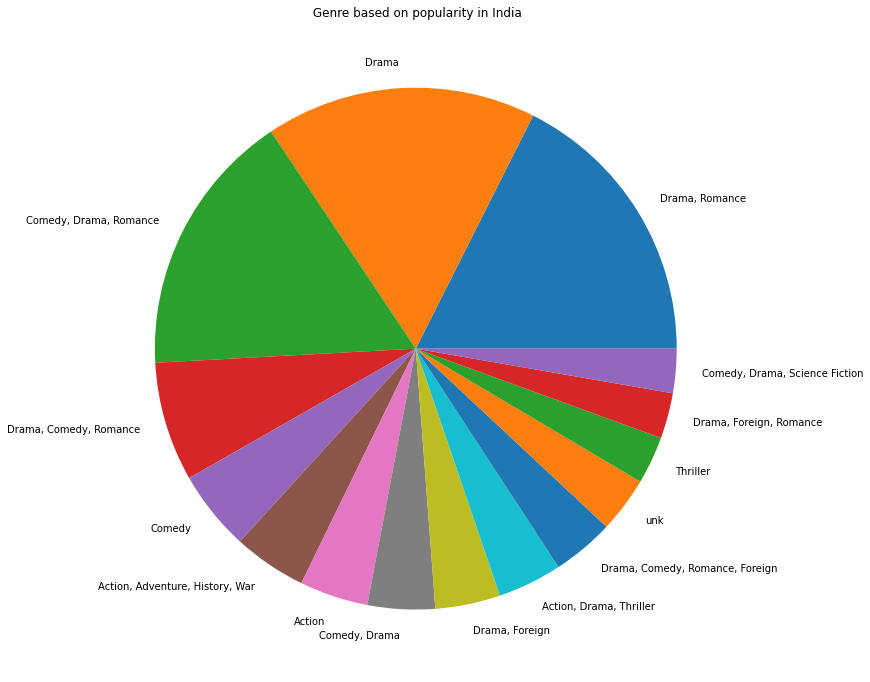

In [284]:
# india
priceQtyConversionStage = {
   '$addFields': {
      
      'converted_popularity': { '$convert': { 
              'input': "$popularity", 
              'to': "double",
              'onError': int("0"),
              'onNull': int("0") 
            }},
        "created_at": { 
            "$dateFromString": { 
                "dateString": "$release_date",
                "format": "%d-%m-%Y" 
            } 
        }
   }
};


s=db.movies_metadata.aggregate( [
   priceQtyConversionStage,
   {'$match':{'production_countries':'India'}},
    {'$group' : {'_id' : "$genres", 'count' : {'$sum' : '$converted_popularity'}}}, 
    {'$sort':{'count':-1}},
    {'$limit':15}
])

ana=[]
for i in s:
    ana.append(i)
    
genre=[]
pop=[]
for i in ana:
    genre.append(i['_id'])
    pop.append(i['count'])

plt.figure(figsize = (12,12))   
plt.pie(np.array(pop), labels = genre)
plt.title(' Genre based on popularity in India')
plt.show()     

#### Trend of vote count in India (shows exposure)

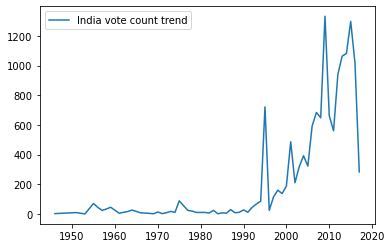

In [293]:
s=db.movies_metadata.aggregate( [
   {'$match':{'production_countries':'India'}},
    {'$project':{'_id' : 0, "release_date":1, 'vote_count':1}}
])

ana=[]
for i in s:
    ana.append(i)
    
release_year=[]
rev=[]
for i in ana:
    release_year.append(datetime.strptime(i['release_date'], '%d-%m-%Y').year)
    rev.append(int(float(i['vote_count'])))

final=np.unique(np.array(release_year))
year_revenue={}
for j in final:
    indices = [i for i, x in enumerate(release_year) if x == j]
    summ=0
    for ind in indices:
        summ+=rev[ind]
    year_revenue[j]=summ


plt.plot(list(year_revenue.keys()),list(year_revenue.values()),label='India vote count trend')
plt.legend()
plt.show()   